<a href="https://colab.research.google.com/github/harshrai654/forex-prediction/blob/main/forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [ ]:
exchange_data = pd.read_csv('forex_data_10y.csv')

exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)
ind_exchange_data.head()

#sort in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-08-26,-0.13%,46.910,46.505,46.825,46.845,0
2010-08-27,-0.07%,47.010,46.565,46.755,46.810,0
2010-08-30,0.22%,46.935,46.385,46.725,46.915,0
2010-08-31,0.32%,47.150,46.505,46.875,47.065,0
2010-09-01,-0.83%,47.045,46.575,47.045,46.675,0


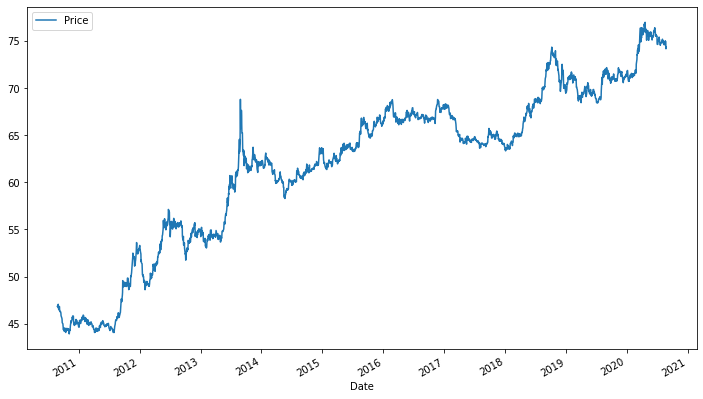

In [ ]:
df = data_frame[["Price"]]
#plotting dataset to visualize the pattern of prices over the years
df.plot(kind='line',figsize=(12,7))

In [ ]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 10 years
80 percent data = 2010 to 2018


In [ ]:
df.describe()

,Price
count,2610.000000
mean,61.902513
std,8.493784
min,43.925000
25%,55.391250
50%,64.008500
75%,67.807250
max,76.975000


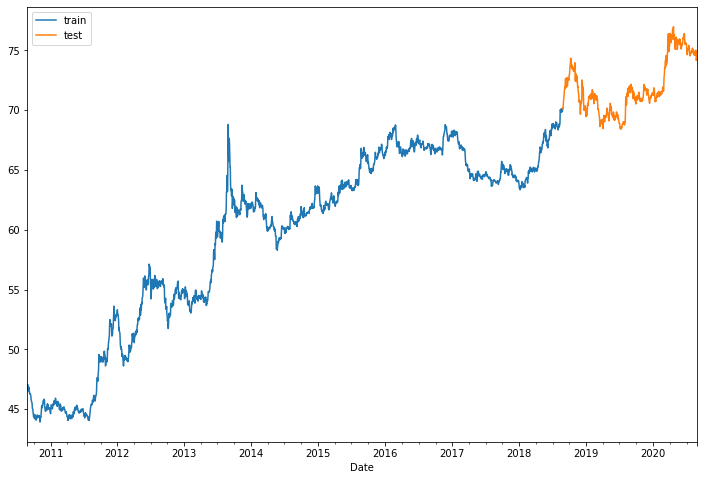

In [ ]:
split_date = pd.Timestamp('26-08-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [ ]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                24        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.2876 - rmse: 0.5362
Epoch 2/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0099 - rmse: 0.0995
Epoch 3/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0047 - rmse: 0.0683
Epoch 4/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0028 - rmse: 0.0531
Epoch 5/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0022 - rmse: 0.0464
Epoch 6/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0019 - rmse: 0.0440
Epoch 7/200
2086/2086 [==============================] - 4s 2ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 8/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 9/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 10/200
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0403
Epoch 11/

In [ ]:
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

66/66 [==============================] - 0s 1ms/step
The R2 score on the Train set is:	0.978
The  MAE on the Train set is:	0.128
The  RMSE on the Train set is:	0.149
The Adjusted R2 score on the Train set is:	0.978

The R2 score on the Test set is:	0.952
The Adjusted R2 score on the Test set is:	0.952
The  MAE on the Test set is:	0.050
The  RMSE on the Test set is:	0.065


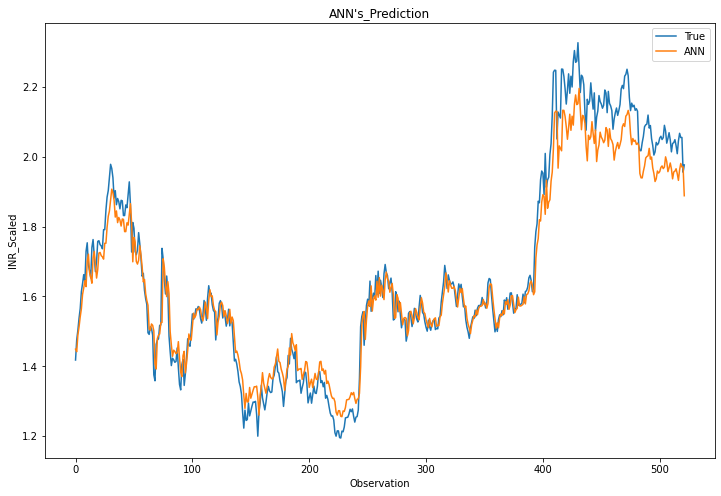

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()